数据集:https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

情感分析，实际上是一个多分类问题
kaggle中这个情感分析，分为消极，有点消极，中立，有点积极，积极 5个分类

0 - negative

1 - somewhat 

2 - neutral

3 - somewhat 

4 - positive

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
sns.set(color_codes=True)

#读取测试集数据


df_test = pd.read_table('D:/my/kaggle/sentiment-analiysis-movie/train.tsv',encoding='utf-8')
df_test.head(2)



,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


In [142]:
#测试集的数据是以短语为单位，每个句子被拆分成一个个的短语。第一行是整个句子，第二行是句子对半切分，后面是短语...
df_test[df_test['SentenceId'] == 1]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [200]:
#由于提交的是对短语的预测结果，因此对短语进行去重处理
df_test['PhraseId'] = df_test.PhraseId.astype(str)
df_test['Sentiment'] = df_test.Sentiment.astype(str)
df_test['Xdata'] = df_test['Sentiment']+'_'+df_test['PhraseId']
df_test.head(10)

def trimsameword(w):
    w = w.split(" ")
    w = list(set(w))
    return " ".join(w)

df_test.Phrase = df_test.Phrase.apply(trimsameword)
t = df_test.Xdata.unique()
len(t)

156060

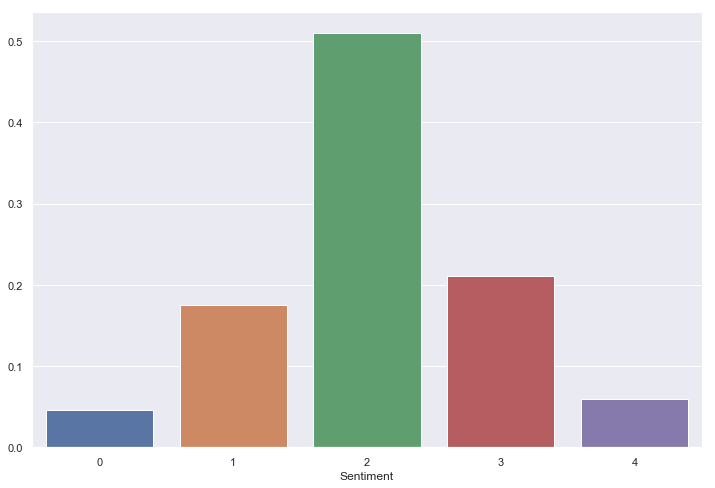

In [201]:
##查看每种情绪的占比
dist = df_test.groupby(["Sentiment"]).size()
dist = dist / dist.sum()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [202]:
# data = df_test.drop_duplicates(["PhraseId"])


In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer
f = feature_extraction.text.CountVectorizer(stop_words = 'english',lowercase=True) 

# X = f.fit_transform(data["Phrase"])
transformer = TfidfVectorizer(min_df=0.000005)
X = transformer.fit_transform(data["Phrase"])
## 看一下去除之后的内容
a = pd.SparseDataFrame(X[0,:]).T
a.describe()

,0
count,24.000000
mean,0.188511
std,0.079980
min,0.068734
25%,0.126111
50%,0.164163
75%,0.259621
max,0.324678


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.3, random_state=82)


In [205]:
from sklearn import metrics


In [208]:
list_alpha = [0.0005,0.003,0.035]#np.arange(0.01, 3, 0.01)


count = 0

def geterror(realres,tranres):

    d = {}
    d['accuracy'] = metrics.accuracy_score(realres, tranres) 
    d['presision'] = metrics.precision_score(realres, tranres,average='macro') 
    d['recall'] = metrics.recall_score(realres, tranres,average='macro')
    d['f1'] = metrics.f1_score(realres, tranres,average='macro')
    return d

testlist = []
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    ytrain_res = bayes.predict(X_train)
    ytest_res = bayes.predict(X_test)
    dtrain = geterror(y_train,ytrain_res)
    dtest = geterror(y_test,ytest_res)
    testlist.append({
        'alpha':alpha,
        'Train Accuracy':dtrain['accuracy'],
        'Test Accuracy':dtest['accuracy'],
        'Test Recall':dtrain['recall'],
        'Test Precision':dtest['presision'],
        'f1':dtest['f1']
    })


    count = count + 1 


models = pd.DataFrame(data = testlist, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision','f1'])
models.head(n=20)




,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision,f1
0,0.0005,0.672159,0.600090,0.489003,0.537936,0.440820
1,0.0030,0.671802,0.600090,0.487881,0.537776,0.440386
2,0.0350,0.670255,0.599022,0.480747,0.537409,0.434285


In [191]:
models['Test Accuracy'].idxmax()

0

In [132]:
models['f1'].idxmax()

8

In [209]:
bayes = naive_bayes.MultinomialNB(alpha=0.0005)
bayes.fit(X_train, y_train)
bayes.score(X_train,y_train)

0.6721590597023123

In [107]:
x_test = pd.read_table('D:/my/kaggle/sentiment-analiysis-movie/test.tsv',encoding='utf-8')

In [214]:
# Xt = f.transform(x_test.Phrase)
Xt=transformer.transform(x_test.Phrase)
predictions = bayes.predict(Xt)
ids = x_test["PhraseId"].copy()
submission = pd.DataFrame(data={
    "PhraseId": ids,
    "Sentiment": predictions
})
submission.to_csv("D:/my/kaggle/sentiment-analiysis-movie/submission06.csv", index=False)
submission.head(n=10).T

,0,1,2,3,4,5,6,7,8,9
PhraseId,156061,156062,156063,156064,156065,156066,156067,156068,156069,156070
Sentiment,3,3,2,3,3,3,3,3,3,2
